In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import geopandas as gpd
from geopandas.tools import sjoin
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString, Polygon
import osmnx as ox
import contextily as ctx
import palettable as pltt
from pyrosm import OSM
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from scipy import stats
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

## 1. Ambulance dataset

### 1.1. Clean and pre-process ambulance dataset

In [3]:
df = pd.read_csv('112_calls_data.csv')
df.head()

pmeId         pmeTimeStamp pmeProtocol1  pmeProtocol2 pmeTarget  \
0  12284699  2017-01-01 00:00:13       FLEX-A          1600      AORG   
1  12284700  2017-01-01 00:00:14       FLEX-A          1600      AORG   
2  12284701  2017-01-01 00:00:23       FLEX-A          1600      AORG   
3  12284702  2017-01-01 00:00:37       FLEX-A          1600      AORG   
4  12284703  2017-01-01 00:00:39       FLEX-A          1600      AORG   

                                          pmeMessage pmePrio pmePrioLevel  \
0  P 1 GEBOUWBRAND Van Heuven Goedhartlaan 2-8 UT...     P 1            1   
1  P 1 VOERTUIGBRAND Wulverhorstlaan UTR Eenh: UT...     P 1            1   
2                                 Gelukkig Nieuwjaar      \N           \N   
3  A1 Goudsbloemlaan 71-79 DHG 2565CP : 15101 Rit...      A1            1   
4  Prio 1 Noord Ringdijk - N207 20,1 MDT Wegvervo...  PRIO 1            1   

  pmeDienst             pmeStrippedMessage  ... pme_strId pme_wplId pme_gemId  \
0         B    GEBOUWBRAND Eenheid: UTR802  ...    181027      4628       357   
1         B  VOERTUIGBRAND Eenheid: UTR902  ...    181244      4628       357   
2         A             Gelukkig Nieuwjaar  ...        \N        \N        \N   
3         A             15101 Ritnummer: 1  ...    199928      4896       391   
4         P      Wegvervoer ongeval letsel  ...        \N      4995      5187   

  pme_proId pme_vrgId                          pmeCapCodes pmeLifeLiner  \
0        10      5164  706001,708442,708443,709563,2029569           \N   
1        10      5164  706001,708470,708473,709563,2029570           \N   
2        \N      5167         126171,126172,126354,2029568           \N   
3        12      5170                              1520001           \N   
4        12      5171                              1533999           \N   

  pme_catId      wplNam   gemName  
0        \N     Utrecht   Utrecht  
1        \N     Utrecht   Utrecht  
2        \N          \N        \N  
3        \N    Den Haag  Den Haag  
4        \N  Moordrecht  Zuidplas  

[5 rows x 31 columns]

In [4]:
# get Den Haag data
df = df[df['gemName'] == 'Den Haag']
# filter for ambulance calls
df = df[(df['pmeDienst']=='A') & ((df['pmePrio']=='A1') | (df['pmePrio']=='A2'))]
# extract month from datetime
df['month'] = pd.DatetimeIndex(pd.to_datetime(df['pmeTimeStamp'])).month
# extract month from datetime
df['year'] = pd.DatetimeIndex(pd.to_datetime(df['pmeTimeStamp'])).year
# filter for years 2017-2019 as 2020 data is incomplete
df = df[(df['year'] == 2017) | (df['year'] == 2018) | (df['year'] == 2019)]
# get neighbourhood from coordinates
df['pmeLongitude'] = pd.to_numeric(df['pmeLongitude'], errors="coerce").fillna(0)
df['pmeLatitude'] = pd.to_numeric(df['pmeLatitude'], errors="coerce").fillna(0)
geometry = [Point(xy) for xy in zip(df['pmeLongitude'], df['pmeLatitude'])]
df_points = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry=geometry) 
# join with neighbourhoods shape file
neigh_shp = gpd.read_file('data/neighborhoods.shp')
gdf_combine = gpd.sjoin(df_points, neigh_shp[['neigb_cijf','geometry', 'neighb_cbs']], how='left', op='intersects')

In [5]:
gdf_combine = gdf_combine[['pmeId', 'pmeTimeStamp', 'pmePrioLevel', 'geometry', 'neigb_cijf', 'neighb_cbs']]
gdf_combine.head()

pmeId         pmeTimeStamp pmePrioLevel                  geometry  \
3    12284702  2017-01-01 00:00:37            1  POINT (4.26075 52.07686)   
82   12284781  2017-01-01 00:12:10            1  POINT (4.27718 52.06738)   
110  12284809  2017-01-01 00:15:54            1  POINT (4.40475 52.07356)   
134  12284833  2017-01-01 00:17:52            1  POINT (4.29638 52.03000)   
272  12284971  2017-01-01 00:30:41            2  POINT (4.25151 52.04957)   

                     neigb_cijf                  neighb_cbs  
3          51 Bloemenbuurt-Oost           Bloemenbuurt-Oost  
82                30 Rustenburg                  Rustenburg  
110               119 De Velden                   De Velden  
134     103 Parkbuurt Oosteinde         Parkbuurt oosteinde  
272  85 Kerketuinen/Zichtenburg  Kerketuinen en Zichtenburg

### 1.2. Exploratory data analysis on ambulance dataset

[Text(0.5, 1.0, 'Proportion of A1 vs A2 priority calls')]

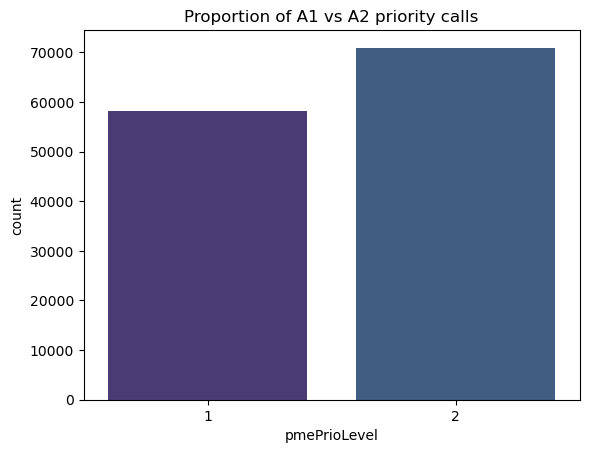

In [6]:
sns.countplot(x='pmePrioLevel', data=gdf_combine, palette=sns.color_palette("viridis")).set(title='Proportion of A1 vs A2 priority calls')

[Text(0.5, 1.0, 'No. of ambulance calls per day over time'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Count')]

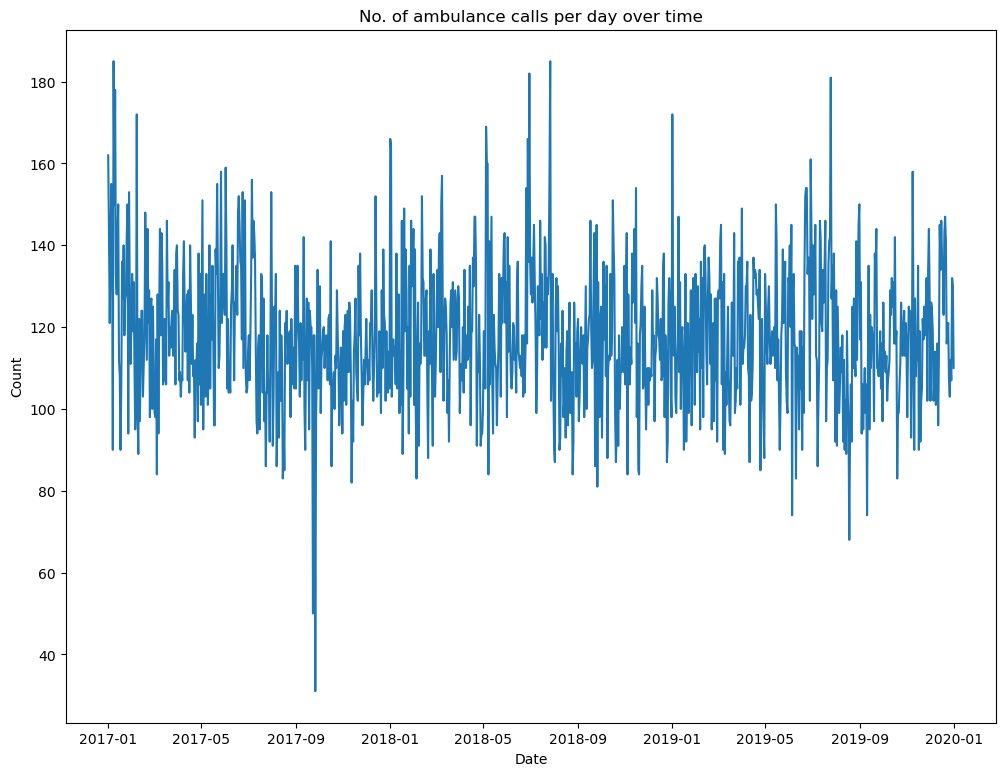

In [7]:
temp = pd.DataFrame(pd.DatetimeIndex(pd.to_datetime(gdf_combine['pmeTimeStamp'])).date)
tempday = temp.groupby([0])[0].count()
f, ax = plt.subplots(1, figsize=(12, 9))
sns.lineplot(data=tempday, ax=ax, palette=sns.color_palette("viridis")).set(title='No. of ambulance calls per day over time', xlabel = 'Date', ylabel='Count')

[Text(0.5, 1.0, 'Boxplot of no. of ambulance calls per day')]

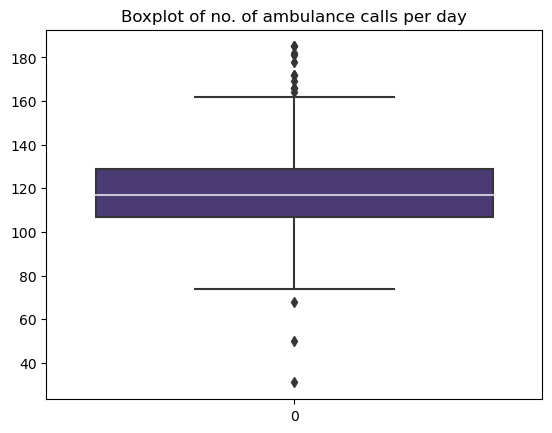

In [8]:
sns.boxplot(data=tempday, palette=sns.color_palette("viridis"), medianprops=dict(color="white", alpha=0.7)).set(title='Boxplot of no. of ambulance calls per day')

In [9]:
# view outliers
q_hi = tempday.quantile(0.99)
q_low = tempday.quantile(0.01)
temp_outliers = tempday[(tempday > q_hi) | (tempday < q_low)]
temp_outliers

0
2017-01-08    185
2017-01-10    178
2017-02-07    172
2017-08-15     83
2017-09-23     50
2017-09-26     31
2017-11-12     82
2018-01-01    166
2018-01-02    164
2018-02-04     83
2018-05-05    169
2018-06-28    166
2018-06-30    182
2018-07-27    185
2018-09-26     81
2019-01-01    172
2019-06-05     74
2019-06-10     83
2019-07-25    181
2019-08-18     68
2019-09-10     74
2019-10-19     83
Name: 0, dtype: int64

[Text(0.5, 1.0, 'No. of ambulance calls by month'), Text(0, 0.5, 'count')]

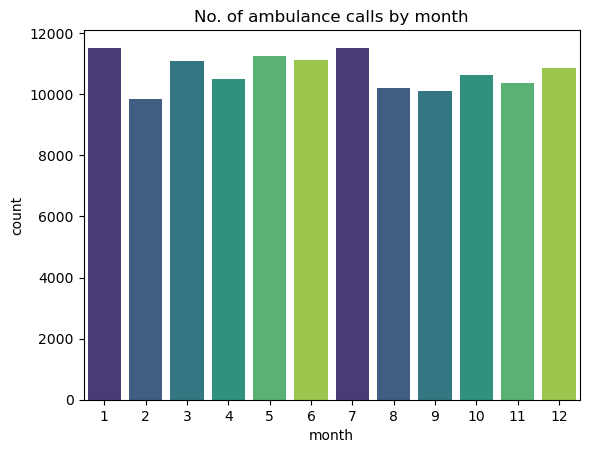

In [10]:
# get month of ambulance call
temp = pd.DataFrame(pd.DatetimeIndex(pd.to_datetime(gdf_combine['pmeTimeStamp'])).month)
# get number of ambulance calls each month
tempmonth = pd.DataFrame(temp.groupby(['pmeTimeStamp'])['pmeTimeStamp'].count())
tempmonth.index.names = ['month']
tempmonth.reset_index(inplace=True)
sns.barplot(data=tempmonth, x='month', y='pmeTimeStamp', palette=sns.color_palette("viridis")).set(title='No. of ambulance calls by month', ylabel='count')

[Text(0.5, 1.0, 'No. of ambulance calls by hour'), Text(0, 0.5, 'count')]

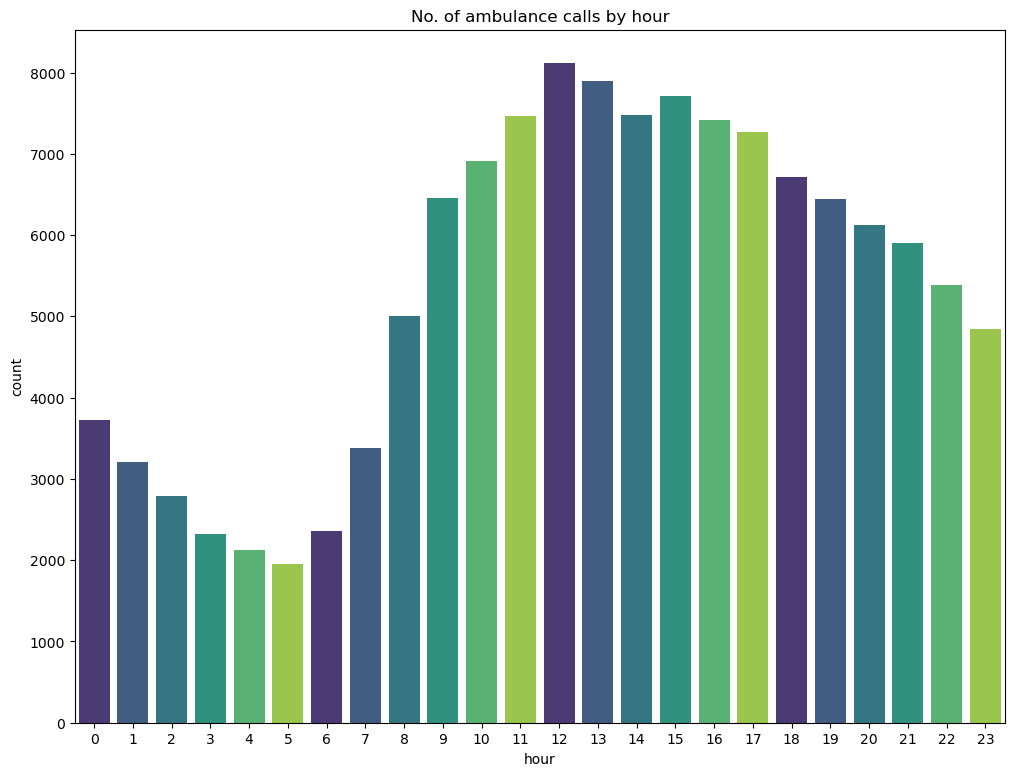

In [11]:
# get hour of ambulance call
temp = pd.DataFrame(pd.to_datetime(gdf_combine['pmeTimeStamp']).apply(lambda x: x.hour))
# get number of ambulance calls by the hour
temphour = pd.DataFrame(temp.groupby(['pmeTimeStamp'])['pmeTimeStamp'].count())
temphour.index.names = ['hour']
temphour.reset_index(inplace=True)
f, ax = plt.subplots(1, figsize=(12, 9))
sns.barplot(data=temphour, x='hour', y='pmeTimeStamp', palette=sns.color_palette("viridis")).set(title='No. of ambulance calls by hour', ylabel='count')

## 2. 2017-2019 CBS dataset

Indicators and related raw columns of interest

`poverty`:  `p_hh_lkk` (% of low income households)

`healthcare services`: `g_afs_hp` (average distance to GP)

`social isolation and loneliness` : `a_1p_hh`/`a_hh` (% of single person household)

`people requiring social assistance`: 
- `a_soz_wb` (no. of people who receive social assistance benefit)
- `a_soz_ao` (no. of people receiving disability benefit)
- `a_soz_ww` (no. of people who receive unemployment benefit)
- `a_soz_ow`: (no. of people receiving pension)
- / `a_inw` (no. of inhabitants in neighbourhood)

### 2.1. Clean CBS dataset

In [12]:
# 2017 data
df_2017 = pd.read_excel('data/kwb-2017.xls')
# extract data for Den Haag
df_2017 = df_2017[(df_2017['gm_naam'] == "'s-Gravenhage") & (df_2017['recs'] == 'Buurt')]
# extract columns of interest
df_2017 = df_2017[['regio', 'gm_naam', 'recs', 'gwb_code', 'p_hh_lkk', 'g_afs_hp', 'a_1p_hh', 'a_hh', 'a_soz_wb', 'a_soz_ao', 'a_soz_ww', 'a_soz_ow', 'a_inw']]
df_2017

regio        gm_naam   recs    gwb_code p_hh_lkk g_afs_hp  \
8042     Oostduinen  's-Gravenhage  Buurt  BU05180170        .        .   
8044  Belgisch Park  's-Gravenhage  Buurt  BU05180271      7,4      0,8   
8046  Westbroekpark  's-Gravenhage  Buurt  BU05180373      6,5      0,8   
8047      Duttendel  's-Gravenhage  Buurt  BU05180374      6,0      1,4   
8049    Nassaubuurt  's-Gravenhage  Buurt  BU05180448      4,4      0,3   
...             ...            ...    ...         ...      ...      ...   
8193    De Rivieren  's-Gravenhage  Buurt  BU05184317        .      1,2   
8195       De Lanen  's-Gravenhage  Buurt  BU05184418      4,0      1,3   
8196      De Velden  's-Gravenhage  Buurt  BU05184419      3,0      1,2   
8197      De Vissen  's-Gravenhage  Buurt  BU05184420      4,9      1,2   
8198      Rietbuurt  's-Gravenhage  Buurt  BU05184421      5,9      0,8   

      a_1p_hh  a_hh a_soz_wb a_soz_ao a_soz_ww a_soz_ow  a_inw  
8042        0     0        .        .        .        .      0  
8044     2135  4210      140      220      110     1560   8145  
8046      210   425       10       20       10      380    845  
8047      185   460       10       20       10      340   1050  
8049      305   735       10       20       20      300   1595  
...       ...   ...      ...      ...      ...      ...    ...  
8193        5     5        .        .        .        .     25  
8195      250  1710       50      160      100      190   5215  
8196      275  1525       50      110       80      360   4230  
8197      570  3040      130      300      160      970   8545  
8198      170   900       50       70       30       90   2700  

[114 rows x 13 columns]

In [13]:
# check for '.' or null and neighbourhoods without any inhabitats
df_2017_na = df_2017[((df_2017.isnull().values) | (df_2017 == '.')).any(axis=1) | (df_2017['a_inw'] == 0)]
df_2017_na

regio        gm_naam   recs    gwb_code p_hh_lkk  \
8042                  Oostduinen  's-Gravenhage  Buurt  BU05180170        .   
8090  Kerketuinen en Zichtenburg  's-Gravenhage  Buurt  BU05181785        .   
8180              Vlietzoom-West  's-Gravenhage  Buurt  BU05184106        .   
8181            Vliegeniersbuurt  's-Gravenhage  Buurt  BU05184107        .   
8182                     De Reef  's-Gravenhage  Buurt  BU05184110        .   
8185               Tedingerbuurt  's-Gravenhage  Buurt  BU05184209        .   
8192              Vlietzoom-Oost  's-Gravenhage  Buurt  BU05184316        .   
8193                 De Rivieren  's-Gravenhage  Buurt  BU05184317        .   

     g_afs_hp  a_1p_hh  a_hh a_soz_wb a_soz_ao a_soz_ww a_soz_ow  a_inw  
8042        .        0     0        .        .        .        .      0  
8090      0,7        5     5        .        .        .        .     45  
8180      1,0       45    85        0       10        0       30    170  
8181        .        0     0        .        .        .        .      0  
8182        .        5     0      110        0        0        0      0  
8185        .        0     0        .        .        .        .      0  
8192      0,8       25    60        0        0        0       40    120  
8193      1,2        5     5        .        .        .        .     25

In [14]:
# 2018 data
df_2018 = pd.read_excel('data/kwb-2018.xls')
# extract data for Den Haag
df_2018 = df_2018[(df_2018['gm_naam'] == "'s-Gravenhage") & (df_2018['recs'] == 'Buurt')]
# extract columns of interest
df_2018 = df_2018[['regio', 'gm_naam', 'recs', 'gwb_code', 'p_hh_lkk', 'g_afs_hp', 'a_1p_hh', 'a_hh', 'a_soz_wb', 'a_soz_ao', 'a_soz_ww', 'a_soz_ow', 'a_inw']]
df_2018

regio        gm_naam   recs    gwb_code p_hh_lkk g_afs_hp  \
7807     Oostduinen  's-Gravenhage  Buurt  BU05180170        .      NaN   
7809  Belgisch Park  's-Gravenhage  Buurt  BU05180271      7,1      0,8   
7811  Westbroekpark  's-Gravenhage  Buurt  BU05180373      7,1      0,8   
7812      Duttendel  's-Gravenhage  Buurt  BU05180374      4,6      1,4   
7814    Nassaubuurt  's-Gravenhage  Buurt  BU05180448      5,9      0,3   
...             ...            ...    ...         ...      ...      ...   
7958    De Rivieren  's-Gravenhage  Buurt  BU05184317        .      1,2   
7960       De Lanen  's-Gravenhage  Buurt  BU05184418      3,8      1,3   
7961      De Velden  's-Gravenhage  Buurt  BU05184419      4,0      1,2   
7962      De Vissen  's-Gravenhage  Buurt  BU05184420      5,0      1,2   
7963      Rietbuurt  's-Gravenhage  Buurt  BU05184421      6,9      0,8   

      a_1p_hh  a_hh a_soz_wb a_soz_ao a_soz_ww a_soz_ow  a_inw  
7807        0     0        .        .        .        .      0  
7809     2115  4205      130      220      120     1550   8205  
7811      225   445       10       20        0      380    880  
7812      185   465       10       20       10      360   1075  
7814      305   750       10       20       20      300   1625  
...       ...   ...      ...      ...      ...      ...    ...  
7958        5     5        .        .        .        .     20  
7960      235  1710       40      160      100      200   5255  
7961      290  1540       40      110       80      370   4220  
7962      580  3035      110      290      140     1000   8505  
7963      195   925       50       70       40      100   2755  

[114 rows x 13 columns]

In [15]:
# check for '.' or null and neighbourhoods without any inhabitatsn
df_2018_na = df_2018[((df_2018.isnull().values) | (df_2018 == '.')).any(axis=1) | (df_2018['a_inw'] == 0)]
df_2018_na

regio        gm_naam   recs    gwb_code p_hh_lkk  \
7807                  Oostduinen  's-Gravenhage  Buurt  BU05180170        .   
7855  Kerketuinen en Zichtenburg  's-Gravenhage  Buurt  BU05181785        .   
7945              Vlietzoom-West  's-Gravenhage  Buurt  BU05184106        .   
7946            Vliegeniersbuurt  's-Gravenhage  Buurt  BU05184107        .   
7947                     De Reef  's-Gravenhage  Buurt  BU05184110        .   
7950               Tedingerbuurt  's-Gravenhage  Buurt  BU05184209        .   
7957              Vlietzoom-Oost  's-Gravenhage  Buurt  BU05184316        .   
7958                 De Rivieren  's-Gravenhage  Buurt  BU05184317        .   

     g_afs_hp  a_1p_hh  a_hh a_soz_wb a_soz_ao a_soz_ww a_soz_ow  a_inw  
7807      NaN        0     0        .        .        .        .      0  
7855      0,7        5     5        0       20        0        0     50  
7945      1,0       45    85        0       10        0       40    170  
7946      NaN        0     0        .        .        .        .      0  
7947      0,7      115   110       70        0        0        0    110  
7950      NaN        0     0        .        .        .        .      0  
7957      0,8       15    45        0        0        0       30    100  
7958      1,2        5     5        .        .        .        .     20

In [16]:
# data for 2019
df_2019 = pd.read_excel('data/kwb-2019.xlsx')
# extract data for Den Haag
df_2019 = df_2019[(df_2019['gm_naam'] == "'s-Gravenhage") & (df_2019['recs'] == 'Buurt')]
# extract columns of interest
df_2019 = df_2019[['regio', 'gm_naam', 'recs', 'gwb_code', 'p_hh_lkk', 'g_afs_hp', 'a_1p_hh', 'a_hh', 'a_soz_wb', 'a_soz_ao', 'a_soz_ww', 'a_soz_ow', 'a_inw']]
df_2019

regio        gm_naam   recs    gwb_code p_hh_lkk g_afs_hp  \
7762     Oostduinen  's-Gravenhage  Buurt  BU05180170        .      NaN   
7764  Belgisch Park  's-Gravenhage  Buurt  BU05180271      6,6      0,7   
7766  Westbroekpark  's-Gravenhage  Buurt  BU05180373      6,9      0,8   
7767      Duttendel  's-Gravenhage  Buurt  BU05180374      4,8      1,3   
7769    Nassaubuurt  's-Gravenhage  Buurt  BU05180448      5,2      0,3   
...             ...            ...    ...         ...      ...      ...   
7913    De Rivieren  's-Gravenhage  Buurt  BU05184317        .      1,1   
7915       De Lanen  's-Gravenhage  Buurt  BU05184418      3,2      1,2   
7916      De Velden  's-Gravenhage  Buurt  BU05184419      3,5      1,2   
7917      De Vissen  's-Gravenhage  Buurt  BU05184420      4,4      1,2   
7918      Rietbuurt  's-Gravenhage  Buurt  BU05184421      6,5      0,8   

      a_1p_hh  a_hh a_soz_wb a_soz_ao a_soz_ww a_soz_ow  a_inw  
7762        0     0        .        .        .        .      0  
7764     2080  4190      130      220      100     1550   8245  
7766      235   475       10       20        0      490    930  
7767      190   470       10       20       10      360   1075  
7769      315   750       10       20       20      300   1610  
...       ...   ...      ...      ...      ...      ...    ...  
7913        5    10        .        .        .        .     40  
7915      260  1795       40      160       80      240   5440  
7916      295  1550       50      110       70      400   4200  
7917      605  3085      110      280      110     1020   8620  
7918      175   925       50       70       30      110   2795  

[114 rows x 13 columns]

In [17]:
# check for '.' or null and neighbourhoods without any inhabitatsn
df_2019_na = df_2019[((df_2019.isnull().values) | (df_2019 == '.')).any(axis=1) | (df_2019['a_inw'] == 0)]
df_2019_na

regio        gm_naam   recs    gwb_code p_hh_lkk  \
7762                  Oostduinen  's-Gravenhage  Buurt  BU05180170        .   
7810  Kerketuinen en Zichtenburg  's-Gravenhage  Buurt  BU05181785        .   
7900              Vlietzoom-West  's-Gravenhage  Buurt  BU05184106        .   
7901            Vliegeniersbuurt  's-Gravenhage  Buurt  BU05184107        .   
7902                     De Reef  's-Gravenhage  Buurt  BU05184110        .   
7905               Tedingerbuurt  's-Gravenhage  Buurt  BU05184209        .   
7912              Vlietzoom-Oost  's-Gravenhage  Buurt  BU05184316        .   
7913                 De Rivieren  's-Gravenhage  Buurt  BU05184317        .   

     g_afs_hp  a_1p_hh  a_hh a_soz_wb a_soz_ao a_soz_ww a_soz_ow  a_inw  
7762      NaN        0     0        .        .        .        .      0  
7810      0,7       10    10        0       20        0        0     55  
7900      0,8       40    80        0       10        0       30    165  
7901      NaN        0     0        .        .        .        .      0  
7902      0,7       95    90       30        0        0        0     95  
7905      NaN        0     0        .        .        .        .      0  
7912      0,8       15    45        0        0        0       30     95  
7913      1,1        5    10        .        .        .        .     40

Across the board, we are missing data for the same neighbourhoods. It is interesting to note that these neighbourhoods have little to no inhabitants and only account for 7% of our dataset therefore we will be dropping these rows.

In [18]:
# drop rows
df_2017 = df_2017[~(((df_2017.isnull().values) | (df_2017 == '.')).any(axis=1) | (df_2017['a_inw'] == 0))]
df_2018 = df_2018[~(((df_2018.isnull().values) | (df_2018 == '.')).any(axis=1) | (df_2018['a_inw'] == 0))]
df_2019 = df_2019[~(((df_2019.isnull().values) | (df_2019 == '.')).any(axis=1) | (df_2019['a_inw'] == 0))]

### 2.2. Pre-process CBS data to get desired indicators

In [19]:
var_columns = ['g_afs_hp', 'p_hh_lkk', 'a_1p_hh', 'a_hh', 'a_soz_wb', 'a_soz_ao', 'a_soz_ww', 'a_soz_ow', 'a_inw']
# typecast columns to float
for col in var_columns:
    df_2017[col] = df_2017[col].astype(str)
    df_2017[col] = df_2017[col].str.replace(',', '.')
    df_2017 = df_2017.astype({col:float})
# preprocess columns to get indicators of interest
df_2017['social_security_perc'] = (df_2017['a_soz_wb'] + df_2017['a_soz_ao'] + df_2017['a_soz_ww'] + df_2017['a_soz_ow']) / df_2017['a_inw']
df_2017['singlep_hh_perc'] = df_2017['a_1p_hh'] / df_2017['a_hh']
# extract final columns of interest
df_2017 = df_2017[['regio', 'gm_naam', 'recs', 'gwb_code', 'p_hh_lkk', 'g_afs_hp', 'singlep_hh_perc', 'social_security_perc', 'a_inw']]
# rename columns
df_2017 = df_2017.rename({'g_afs_hp':'dist_gp', 'p_hh_lkk': 'low_income_perc', 'a_inw': 'population'}, axis='columns')
df_2017.head()

regio        gm_naam   recs    gwb_code  low_income_perc  \
8044  Belgisch Park  's-Gravenhage  Buurt  BU05180271              7.4   
8046  Westbroekpark  's-Gravenhage  Buurt  BU05180373              6.5   
8047      Duttendel  's-Gravenhage  Buurt  BU05180374              6.0   
8049    Nassaubuurt  's-Gravenhage  Buurt  BU05180448              4.4   
8050      Uilennest  's-Gravenhage  Buurt  BU05180475              3.8   

      dist_gp  singlep_hh_perc  social_security_perc  population  
8044      0.8         0.507126              0.249233      8145.0  
8046      0.8         0.494118              0.497041       845.0  
8047      1.4         0.402174              0.361905      1050.0  
8049      0.3         0.414966              0.219436      1595.0  
8050      1.2         0.537445              0.301435      2090.0

In [20]:
# typecast columns to float
for col in var_columns:
    df_2018[col] = df_2018[col].astype(str)
    df_2018[col] = df_2018[col].str.replace(',', '.')
    df_2018 = df_2018.astype({col:float})
# preprocess columns to get indicators of interest
df_2018['social_security_perc'] = (df_2018['a_soz_wb'] + df_2018['a_soz_ao'] + df_2018['a_soz_ww'] + df_2018['a_soz_ow']) / df_2018['a_inw']
df_2018['singlep_hh_perc'] = df_2018['a_1p_hh'] / df_2018['a_hh']
# extract final columns of interest
df_2018 = df_2018[['regio', 'gm_naam', 'recs', 'gwb_code', 'p_hh_lkk', 'g_afs_hp', 'singlep_hh_perc', 'social_security_perc', 'a_inw']]
# rename columns
df_2018 = df_2018.rename({'g_afs_hp':'dist_gp', 'p_hh_lkk': 'low_income_perc', 'a_inw': 'population'}, axis='columns')
df_2018.head()

regio        gm_naam   recs    gwb_code  low_income_perc  \
7809  Belgisch Park  's-Gravenhage  Buurt  BU05180271              7.1   
7811  Westbroekpark  's-Gravenhage  Buurt  BU05180373              7.1   
7812      Duttendel  's-Gravenhage  Buurt  BU05180374              4.6   
7814    Nassaubuurt  's-Gravenhage  Buurt  BU05180448              5.9   
7815      Uilennest  's-Gravenhage  Buurt  BU05180475              3.2   

      dist_gp  singlep_hh_perc  social_security_perc  population  
7809      0.8         0.502973              0.246191      8205.0  
7811      0.8         0.505618              0.465909       880.0  
7812      1.4         0.397849              0.372093      1075.0  
7814      0.3         0.406667              0.215385      1625.0  
7815      1.3         0.537118              0.290476      2100.0

In [21]:
# typecast columns to float
for col in var_columns:
    df_2019[col] = df_2019[col].astype(str)
    df_2019[col] = df_2019[col].str.replace(',', '.')
    df_2019 = df_2019.astype({col:float})
# preprocess columns to get indicators of interest
df_2019['social_security_perc'] = (df_2019['a_soz_wb'] + df_2019['a_soz_ao'] + df_2019['a_soz_ww'] + df_2019['a_soz_ow']) / df_2019['a_inw']
df_2019['singlep_hh_perc'] = df_2019['a_1p_hh'] / df_2019['a_hh']
# extract final columns of interest
df_2019 = df_2019[['regio', 'gm_naam', 'recs', 'gwb_code', 'p_hh_lkk', 'g_afs_hp', 'singlep_hh_perc', 'social_security_perc', 'a_inw']]
# rename columns
df_2019 = df_2019.rename({'g_afs_hp':'dist_gp', 'p_hh_lkk': 'low_income_perc', 'a_inw': 'population'}, axis='columns')
df_2019.head()

regio        gm_naam   recs    gwb_code  low_income_perc  \
7764  Belgisch Park  's-Gravenhage  Buurt  BU05180271              6.6   
7766  Westbroekpark  's-Gravenhage  Buurt  BU05180373              6.9   
7767      Duttendel  's-Gravenhage  Buurt  BU05180374              4.8   
7769    Nassaubuurt  's-Gravenhage  Buurt  BU05180448              5.2   
7770      Uilennest  's-Gravenhage  Buurt  BU05180475              2.8   

      dist_gp  singlep_hh_perc  social_security_perc  population  
7764      0.7         0.496420              0.242571      8245.0  
7766      0.8         0.494737              0.559140       930.0  
7767      1.3         0.404255              0.372093      1075.0  
7769      0.3         0.420000              0.217391      1610.0  
7770      1.3         0.532751              0.275534      2105.0

In [22]:
# aggregate data across years
df_concat = (pd.concat([df_2017, df_2018, df_2019]).groupby(['regio', 'gm_naam', 'recs', 'gwb_code'], as_index=False).agg({'low_income_perc':'mean', 'dist_gp':'mean', 'singlep_hh_perc':'mean', 'social_security_perc':'mean', 'population': 'mean'}))
df_concat.head()

regio        gm_naam   recs    gwb_code  low_income_perc  \
0        Archipelbuurt  's-Gravenhage  Buurt  BU05180546         6.400000   
1           Arendsdorp  's-Gravenhage  Buurt  BU05180478         5.366667   
2        Belgisch Park  's-Gravenhage  Buurt  BU05180271         7.033333   
3  Bezuidenhout-Midden  's-Gravenhage  Buurt  BU05182665         5.133333   
4    Bezuidenhout-Oost  's-Gravenhage  Buurt  BU05182666         5.566667   

    dist_gp  singlep_hh_perc  social_security_perc   population  
0  0.300000         0.552249              0.248590  6061.666667  
1  0.600000         0.439747              0.265939  1328.333333  
2  0.766667         0.502173              0.245998  8198.333333  
3  0.600000         0.529711              0.162227  4278.333333  
4  0.400000         0.525625              0.184609  9028.333333

In [23]:
# merge indicators with no. of ambulance calls
df_concat = df_concat.set_index('regio')
temp = pd.DataFrame(gdf_combine.groupby('neighb_cbs').size())
temp = temp.rename({0: 'count'}, axis='columns')
geo_pop = temp.join(df_concat)
geo_pop.dropna(inplace=True)
geo_pop.head()

count        gm_naam   recs    gwb_code  low_income_perc  \
neighb_cbs                                                                      
Archipelbuurt         1570  's-Gravenhage  Buurt  BU05180546         6.400000   
Arendsdorp             400  's-Gravenhage  Buurt  BU05180478         5.366667   
Belgisch Park         2272  's-Gravenhage  Buurt  BU05180271         7.033333   
Bezuidenhout-Midden   1100  's-Gravenhage  Buurt  BU05182665         5.133333   
Bezuidenhout-Oost     1071  's-Gravenhage  Buurt  BU05182666         5.566667   

                      dist_gp  singlep_hh_perc  social_security_perc  \
neighb_cbs                                                             
Archipelbuurt        0.300000         0.552249              0.248590   
Arendsdorp           0.600000         0.439747              0.265939   
Belgisch Park        0.766667         0.502173              0.245998   
Bezuidenhout-Midden  0.600000         0.529711              0.162227   
Bezuidenhout-Oost    0.400000         0.525625              0.184609   

                      population  
neighb_cbs                        
Archipelbuurt        6061.666667  
Arendsdorp           1328.333333  
Belgisch Park        8198.333333  
Bezuidenhout-Midden  4278.333333  
Bezuidenhout-Oost    9028.333333

In [24]:
# normalize ambulance calls to population, per 1000 people
geo_pop['norm_count'] = (geo_pop['count'] / geo_pop['population']) * 1000
geo_pop.head()

count        gm_naam   recs    gwb_code  low_income_perc  \
neighb_cbs                                                                      
Archipelbuurt         1570  's-Gravenhage  Buurt  BU05180546         6.400000   
Arendsdorp             400  's-Gravenhage  Buurt  BU05180478         5.366667   
Belgisch Park         2272  's-Gravenhage  Buurt  BU05180271         7.033333   
Bezuidenhout-Midden   1100  's-Gravenhage  Buurt  BU05182665         5.133333   
Bezuidenhout-Oost     1071  's-Gravenhage  Buurt  BU05182666         5.566667   

                      dist_gp  singlep_hh_perc  social_security_perc  \
neighb_cbs                                                             
Archipelbuurt        0.300000         0.552249              0.248590   
Arendsdorp           0.600000         0.439747              0.265939   
Belgisch Park        0.766667         0.502173              0.245998   
Bezuidenhout-Midden  0.600000         0.529711              0.162227   
Bezuidenhout-Oost    0.400000         0.525625              0.184609   

                      population  norm_count  
neighb_cbs                                    
Archipelbuurt        6061.666667  259.004674  
Arendsdorp           1328.333333  301.129235  
Belgisch Park        8198.333333  277.129498  
Bezuidenhout-Midden  4278.333333  257.109466  
Bezuidenhout-Oost    9028.333333  118.626546

### 2.3. Exploratory data analysis on indicators from CBS data

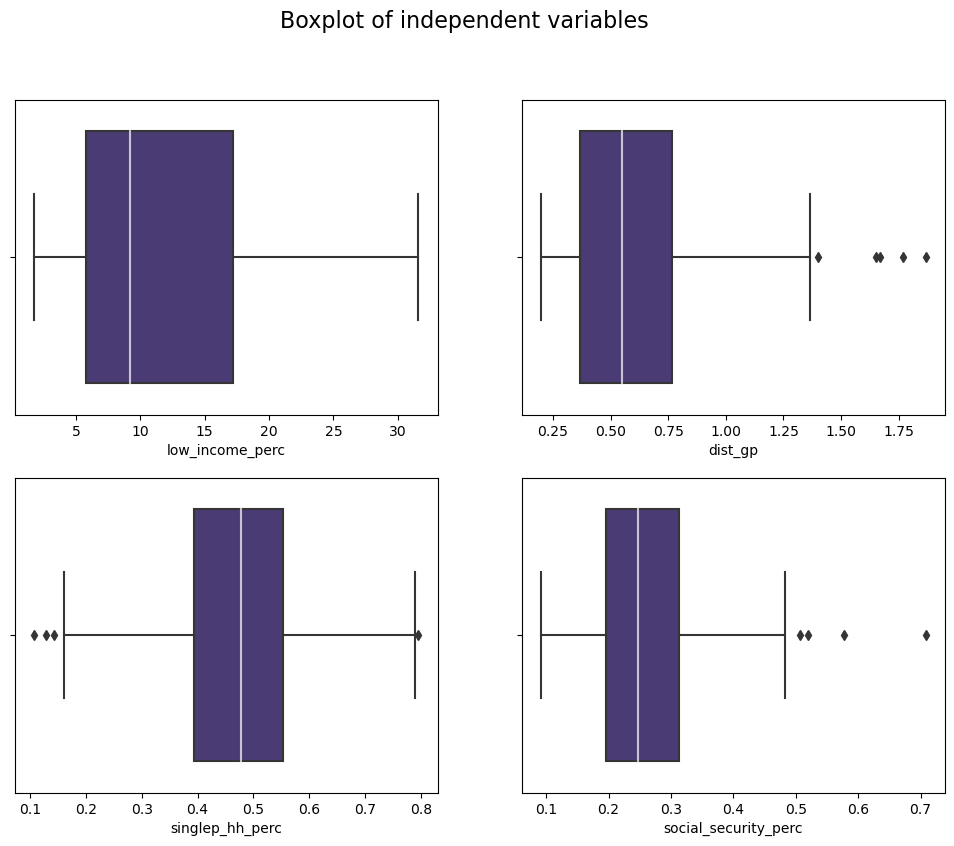

In [25]:
var_columns = ['low_income_perc', 'dist_gp', 'singlep_hh_perc', 'social_security_perc']
fig, axs = plt.subplots(2,2, figsize=(12,9))
fig.suptitle('Boxplot of independent variables', size=16)
k = 0
for i in range(2):
    for j in range(2):
        try:
            plot = sns.boxplot(x=var_columns[k], data=geo_pop, ax=axs[i,j], palette=sns.color_palette("viridis"), medianprops=dict(color="white", alpha=0.7))
            k += 1
        except:
            break

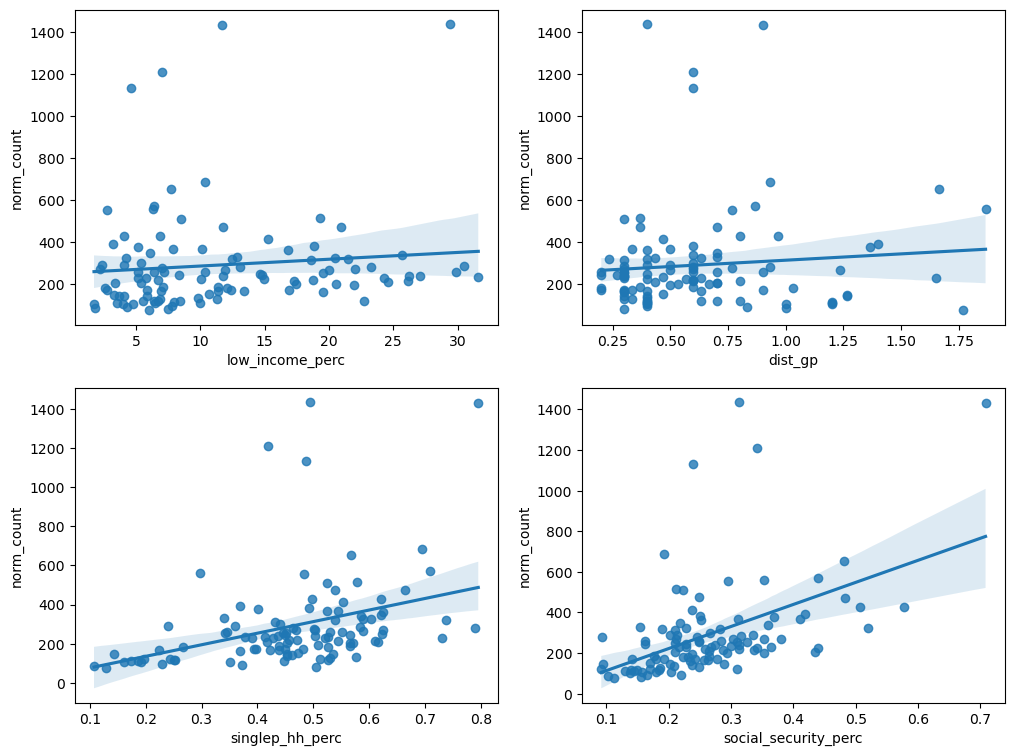

In [26]:
fig, axs = plt.subplots(2,2, figsize=(12,9))
k = 0
for i in range(2):
    for j in range(2):
        try:
            plot = sns.regplot(x=var_columns[k], y='norm_count', data=geo_pop, ax=axs[i,j])
            k += 1
        except:
            break

In [27]:
low_income_corr = np.corrcoef(geo_pop["low_income_perc"], geo_pop["norm_count"])[0,1]
dist_gp_corr = np.corrcoef(geo_pop["dist_gp"], geo_pop["norm_count"])[0,1]
singlep_hh_corr = np.corrcoef(geo_pop["singlep_hh_perc"], geo_pop["norm_count"])[0,1]
social_security_corr = np.corrcoef(geo_pop["social_security_perc"], geo_pop["norm_count"])[0,1]
print(f"Correlation coefficient between percentage of low income households and no. of ambulance calls: {low_income_corr}")
print(f"Correlation coefficient between average distance to GP and no. of ambulance calls: {dist_gp_corr}")
print(f"Correlation coefficient between percentage of single person household and no. of ambulance calls: {singlep_hh_corr}")
print(f"Correlation coefficient between percentage of population receiving social benefits and no. of ambulance calls: {social_security_corr}")

Correlation coefficient between percentage of low income households and no. of ambulance calls: 0.10411727276757513
Correlation coefficient between average distance to GP and no. of ambulance calls: 0.0908795076602941
Correlation coefficient between percentage of single person household and no. of ambulance calls: 0.3570575006827822
Correlation coefficient between percentage of population receiving social benefits and no. of ambulance calls: 0.48205894523340365


<AxesSubplot:>

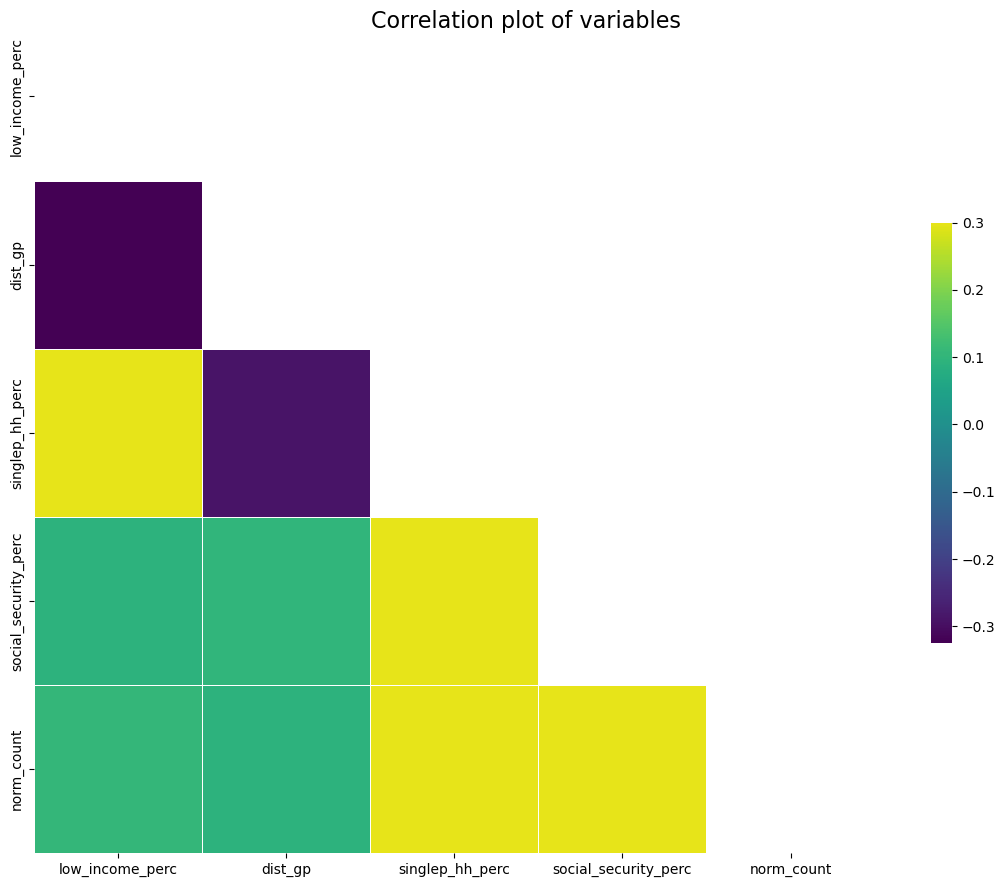

In [28]:
# extract factors of interest
geo_pop_corr = geo_pop[['low_income_perc', 'dist_gp', 'singlep_hh_perc', 'social_security_perc', 'norm_count']]

# Compute the correlation matrix
corr = geo_pop_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))
plt.tight_layout()
f.suptitle('Correlation plot of variables', size=16)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=sns.color_palette("viridis", as_cmap=True), vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 3. Spatial exploratory data analysis on CBS dataset

In [29]:
geo_pop_df = GeoDataFrame(geo_pop.join(neigh_shp.set_index('neighb_cbs')))
geo_pop_df.head()

count        gm_naam   recs    gwb_code  low_income_perc  \
neighb_cbs                                                                      
Archipelbuurt         1570  's-Gravenhage  Buurt  BU05180546         6.400000   
Arendsdorp             400  's-Gravenhage  Buurt  BU05180478         5.366667   
Belgisch Park         2272  's-Gravenhage  Buurt  BU05180271         7.033333   
Bezuidenhout-Midden   1100  's-Gravenhage  Buurt  BU05182665         5.133333   
Bezuidenhout-Oost     1071  's-Gravenhage  Buurt  BU05182666         5.566667   

                      dist_gp  singlep_hh_perc  social_security_perc  \
neighb_cbs                                                             
Archipelbuurt        0.300000         0.552249              0.248590   
Arendsdorp           0.600000         0.439747              0.265939   
Belgisch Park        0.766667         0.502173              0.245998   
Bezuidenhout-Midden  0.600000         0.529711              0.162227   
Bezuidenhout-Oost    0.400000         0.525625              0.184609   

                      population  norm_count              neigb_cijf  \
neighb_cbs                                                             
Archipelbuurt        6061.666667  259.004674        46 Archipelbuurt   
Arendsdorp           1328.333333  301.129235           78 Arendsdorp   
Belgisch Park        8198.333333  277.129498        71 Belgisch Park   
Bezuidenhout-Midden  4278.333333  257.109466  65 Bezuidenhout-Midden   
Bezuidenhout-Oost    9028.333333  118.626546    66 Bezuidenhout-Oost   

                                                              geometry  
neighb_cbs                                                              
Archipelbuurt        POLYGON ((4.30625 52.09663, 4.30628 52.09661, ...  
Arendsdorp           POLYGON ((4.32329 52.09921, 4.32388 52.09870, ...  
Belgisch Park        POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...  
Bezuidenhout-Midden  POLYGON ((4.33470 52.08804, 4.33504 52.08776, ...  
Bezuidenhout-Oost    POLYGON ((4.34235 52.09126, 4.34241 52.09121, ...

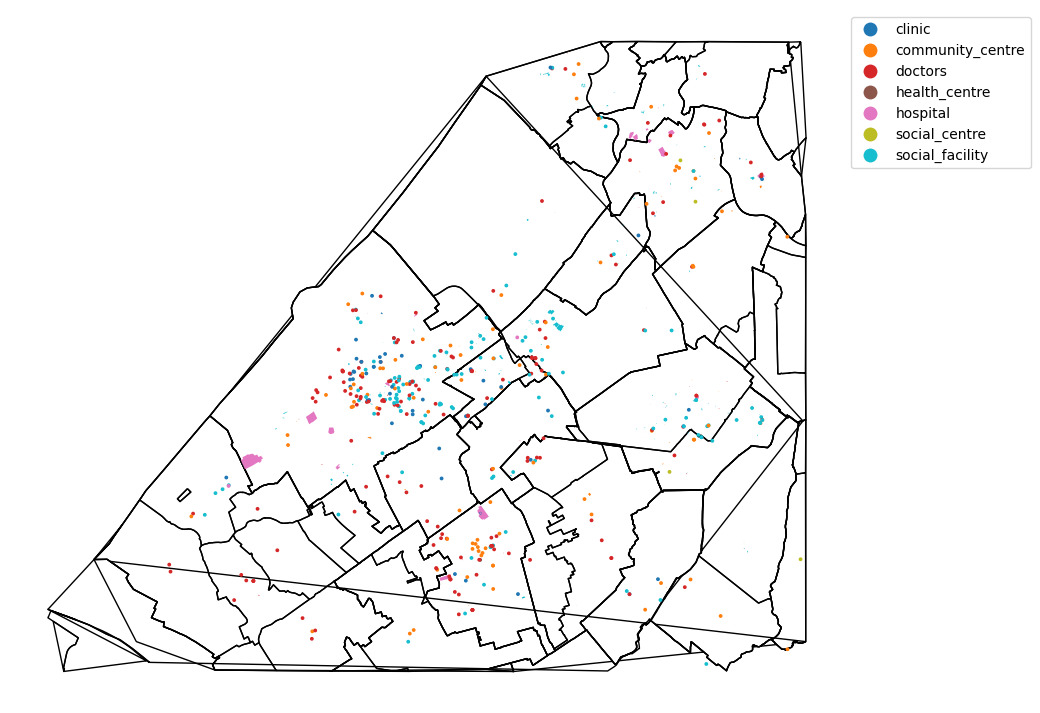

In [30]:
# Initialize the OSM parser object
osm = OSM("data/DenHaag_osm.pbf")

# get amenity
custom_filter = {'amenity': ["clinic", "community_centre", "doctors", "health_centre", "hospital", "social_centre", "social_facility"]}
pois = osm.get_pois(custom_filter=custom_filter)

# Gather info about POI type
pois["poi_type"] = pois["amenity"]

# Plot
f, ax = plt.subplots(1, figsize=(12, 9))
boundaries = osm.get_boundaries()
boundaries.plot(facecolor="none", ax=ax)
pois.plot(column='poi_type', markersize=3, ax=ax, legend=True, legend_kwds=dict(loc='upper left', ncol=1, bbox_to_anchor=(1, 1)))
ax.set_axis_off()

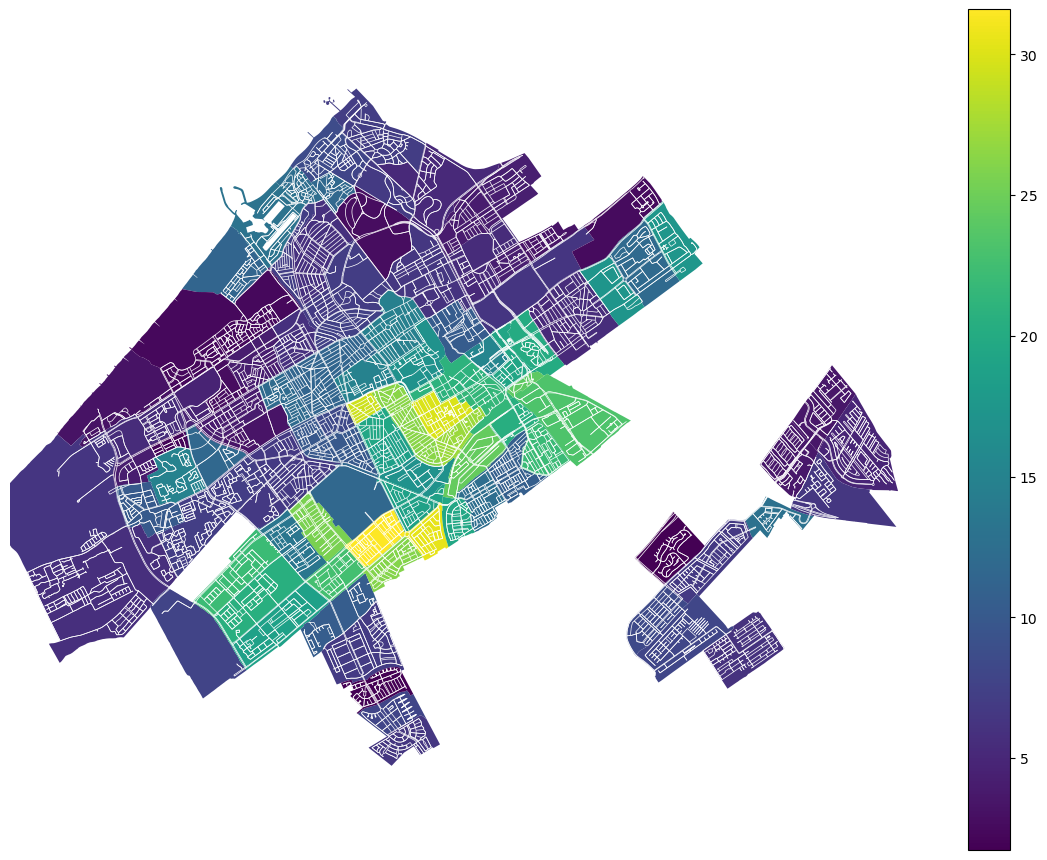

In [31]:
f, ax = plt.subplots(1, figsize=(12, 9))
plt.tight_layout()

# plot chloropleth
geo_pop_df.plot(
        ax=ax, 
        column='low_income_perc', 
        missing_kwds={
            "color": "lightgrey",
            "hatch": "///",
            "label": "Missing values",
        },
        cmap=sns.color_palette("viridis", as_cmap=True),
        legend=True
)

# plot street
ox.config(use_cache=True, log_console=True)
G = ox.graph_from_place('Den Haag', network_type='drive')
ox.plot_graph(G, ax=ax, node_size=0, edge_color='w', node_zorder=3, edge_linewidth=0.5)

f.suptitle('Percentage of low income households', size=16)
ax.set_axis_off()

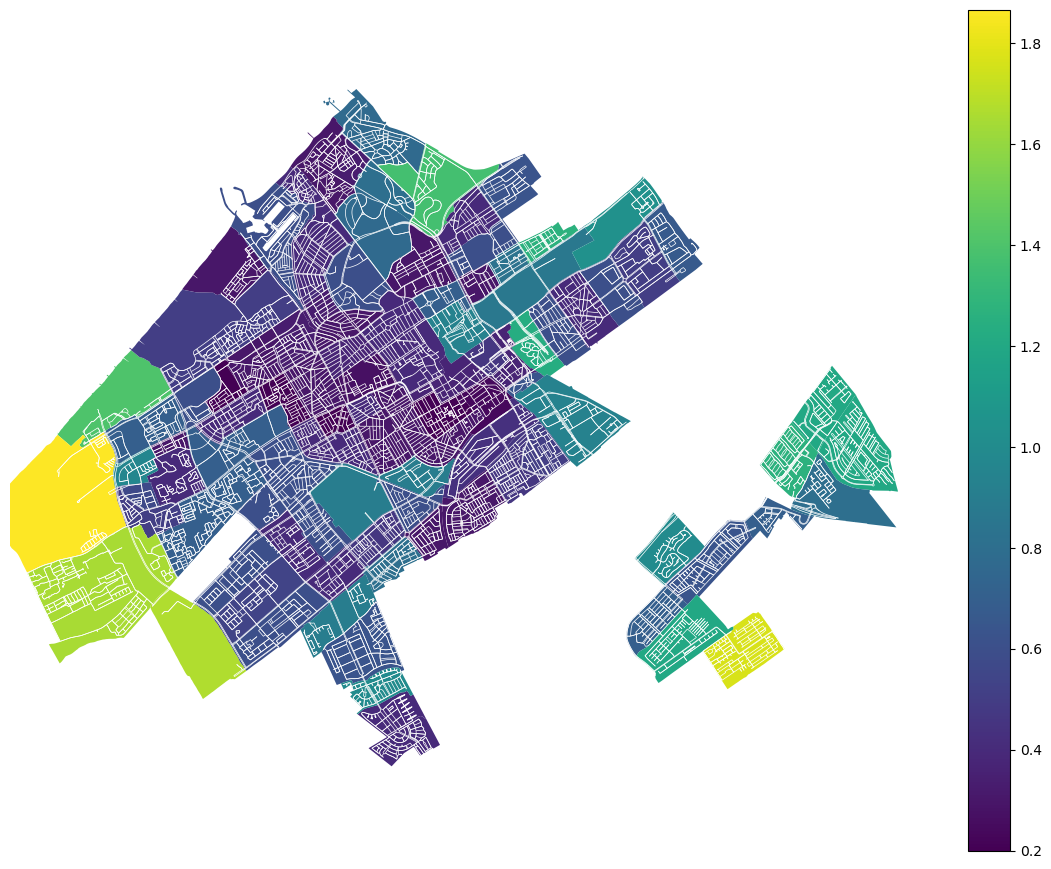

In [32]:
f, ax = plt.subplots(1, figsize=(12, 9))
plt.tight_layout()

# plot chloropleth
geo_pop_df.plot(
        ax=ax, 
        column='dist_gp', 
        missing_kwds={
            "color": "lightgrey",
            "hatch": "///",
            "label": "Missing values",
        },
        cmap=sns.color_palette("viridis", as_cmap=True),
        legend=True
)

# plot street
ox.config(use_cache=True, log_console=True)
G = ox.graph_from_place('Den Haag', network_type='drive')
ox.plot_graph(G, ax=ax, node_size=0, edge_color='w', node_zorder=3, edge_linewidth=0.5)

f.suptitle('Average distance to GP (km)', size=16)
ax.set_axis_off()

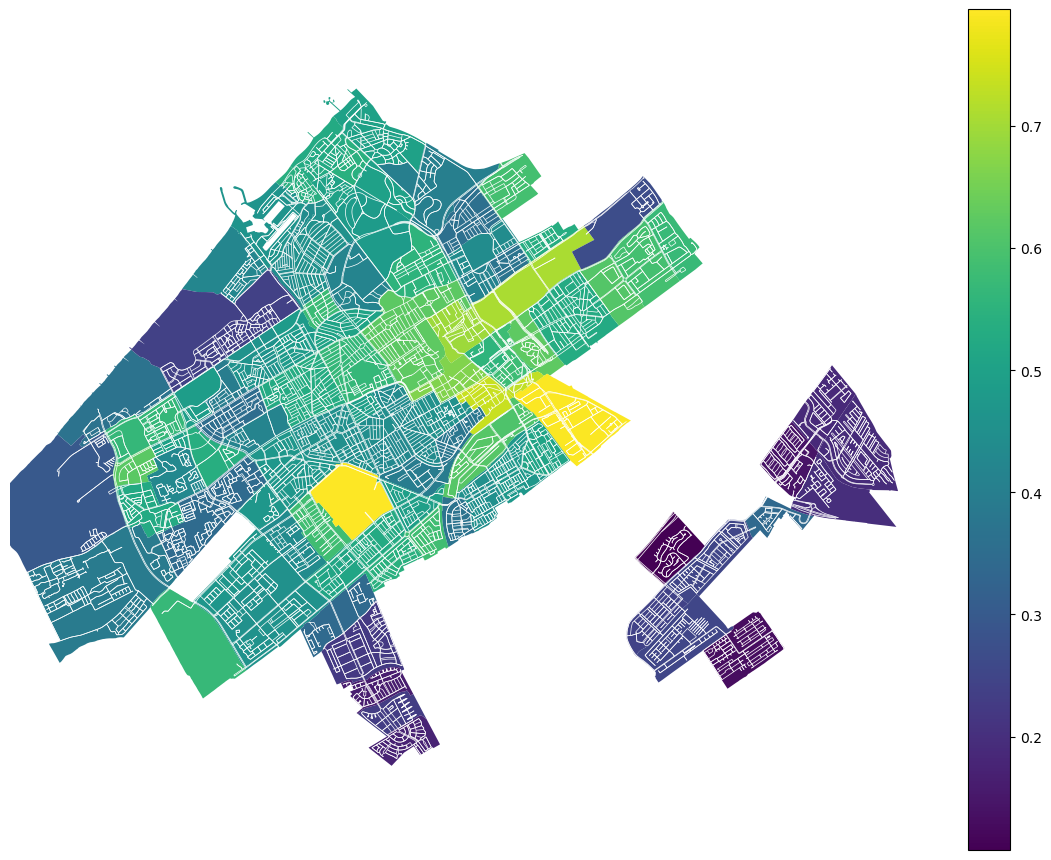

In [33]:
f, ax = plt.subplots(1, figsize=(12, 9))
plt.tight_layout()

# plot chloropleth
geo_pop_df.plot(
        ax=ax, 
        column='singlep_hh_perc', 
        missing_kwds={
            "color": "lightgrey",
            "hatch": "///",
            "label": "Missing values",
        },
        cmap=sns.color_palette("viridis", as_cmap=True),
        legend=True
)

# plot street
ox.config(use_cache=True, log_console=True)
G = ox.graph_from_place('Den Haag', network_type='drive')
ox.plot_graph(G, ax=ax, node_size=0, edge_color='w', node_zorder=3, edge_linewidth=0.5)

f.suptitle('Percentage of single person households', size=16)
ax.set_axis_off()

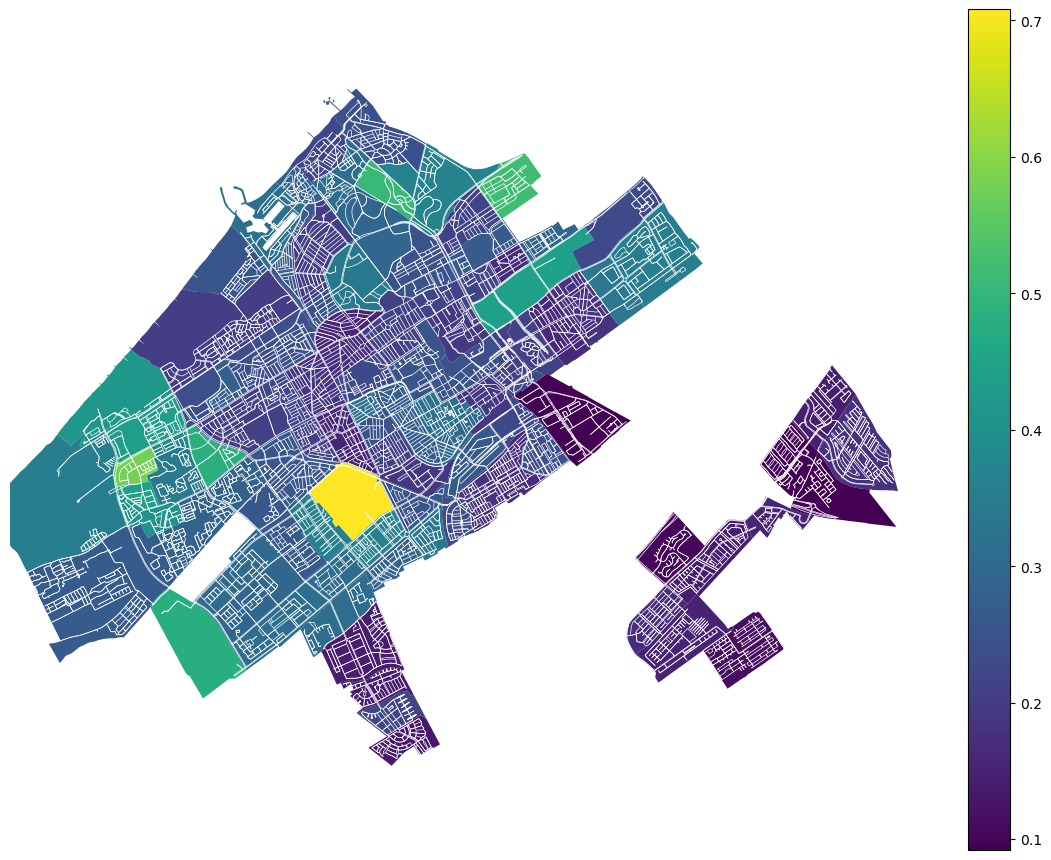

In [34]:
f, ax = plt.subplots(1, figsize=(12, 9))
plt.tight_layout()

# plot chloropleth
geo_pop_df.plot(
        ax=ax, 
        column='social_security_perc', 
        missing_kwds={
            "color": "lightgrey",
            "hatch": "///",
            "label": "Missing values",
        },
        cmap=sns.color_palette("viridis", as_cmap=True),
        legend=True
)

# plot street
ox.config(use_cache=True, log_console=True)
G = ox.graph_from_place('Den Haag', network_type='drive')
ox.plot_graph(G, ax=ax, node_size=0, edge_color='w', node_zorder=3, edge_linewidth=0.5)

f.suptitle('Percentage of households with social benefits', size=16)
ax.set_axis_off()

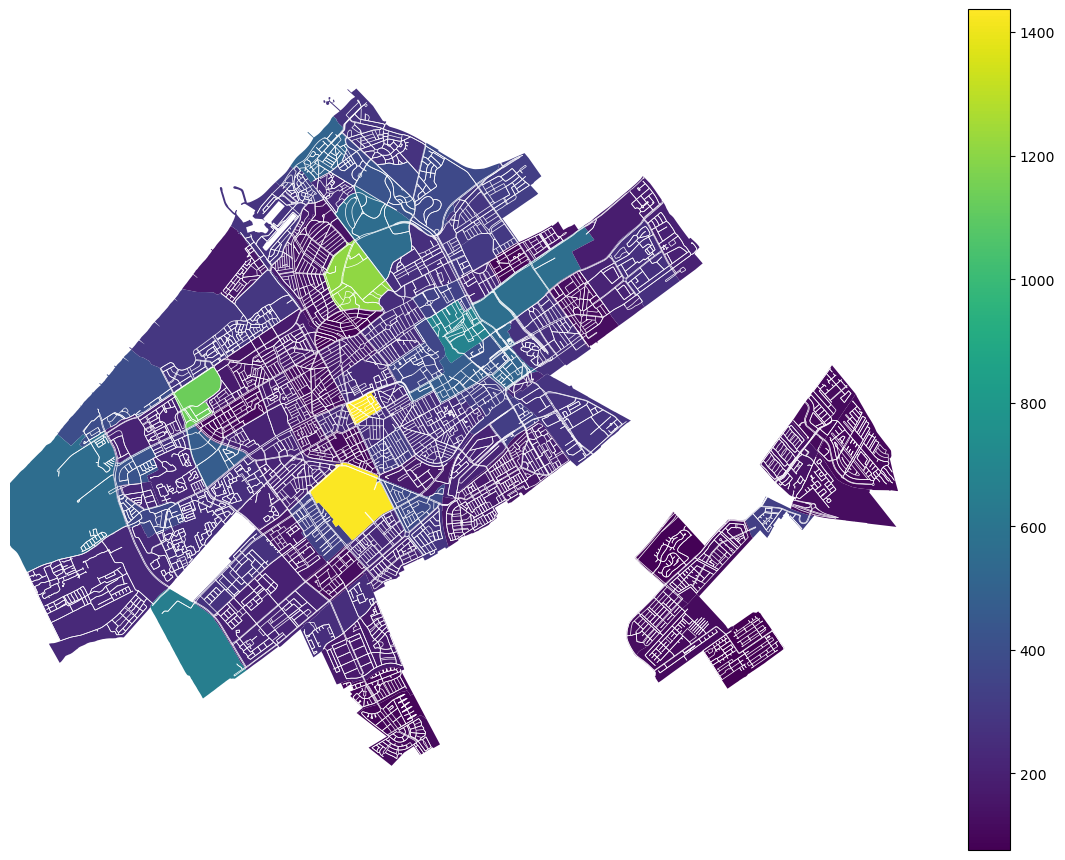

In [35]:
f, ax = plt.subplots(1, figsize=(12, 9))
plt.tight_layout()

# plot chloropleth
geo_pop_df.plot(
        ax=ax, 
        column='norm_count', 
        missing_kwds={
            "color": "lightgrey",
            "hatch": "///",
            "label": "Missing values",
        },
        cmap=sns.color_palette("viridis", as_cmap=True),
        legend=True
)

# plot street
ox.config(use_cache=True, log_console=True)
G = ox.graph_from_place('Den Haag', network_type='drive')
ox.plot_graph(G, ax=ax, node_size=0, edge_color='w', node_zorder=3, edge_linewidth=0.5)

f.suptitle('Total no. of ambulance calls 2017-2019', size=16)
ax.set_axis_off()

In [36]:
# spatial autocorrelation for single person household
w = weights.Queen.from_dataframe(df=geo_pop_df, idVariable='singlep_hh_perc')
# Row standardize the matrix
w.transform = 'R'
# standardize housing price column for spatial autocorrelation analysis
geo_pop_df['singlep_hh_perc_std'] = (geo_pop_df['singlep_hh_perc'] - geo_pop_df['singlep_hh_perc'].mean()) / geo_pop_df['singlep_hh_perc'].std()
geo_pop_df['w_singlep_hh_perc_std'] = weights.lag_spatial(w, geo_pop_df['singlep_hh_perc_std'])
geo_pop_df[['gwb_code', 'singlep_hh_perc_std', 'w_singlep_hh_perc_std']].head()

gwb_code  singlep_hh_perc_std  w_singlep_hh_perc_std
neighb_cbs                                                                 
Archipelbuurt        BU05180546             0.612760               0.517164
Arendsdorp           BU05180478            -0.167324              -2.473838
Belgisch Park        BU05180271             0.265535               1.123674
Bezuidenhout-Midden  BU05182665             0.456484               0.124016
Bezuidenhout-Oost    BU05182666             0.428149               0.710589

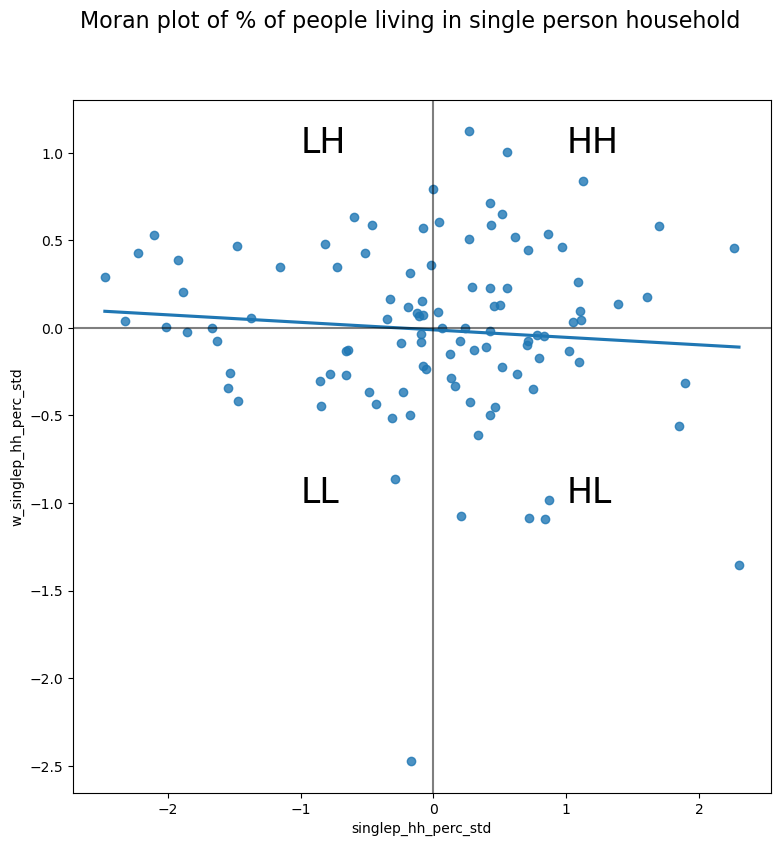

In [37]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='singlep_hh_perc_std', y='w_singlep_hh_perc_std', data=geo_pop_df, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1, 1, "HH", fontsize=25)
plt.text(1, -1, "HL", fontsize=25)
plt.text(-1, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
# title 
f.suptitle('Moran plot of % of people living in single person household', size=16)
# Display
plt.show()

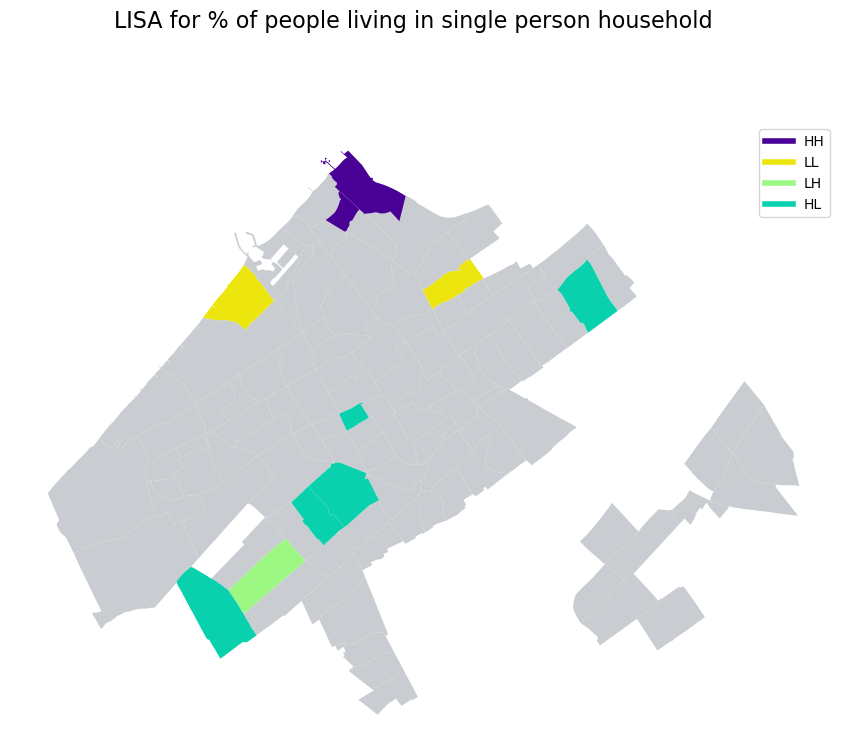

In [38]:
lisa = esda.Moran_Local(geo_pop_df['singlep_hh_perc'], w)
# Break observations into significant or not
geo_pop_df['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
geo_pop_df['quadrant'] = lisa.q

# plot LISA
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
plt.tight_layout()
# Plot insignificant clusters
ns = geo_pop_df.loc[geo_pop_df['significant']==False, 'geometry']
ns.plot(ax=ax, color='#c9cdd1')
# Plot HH clusters (dark purple)
hh = geo_pop_df.loc[(geo_pop_df['quadrant']==1) & (geo_pop_df['significant']==True), 'geometry']
hh.plot(ax=ax, color='#480194')
# Plot LL clusters (yellow)
ll = geo_pop_df.loc[(geo_pop_df['quadrant']==3) & (geo_pop_df['significant']==True), 'geometry']
ll.plot(ax=ax, color='#ede60e')
# Plot LH clusters (green)
lh = geo_pop_df.loc[(geo_pop_df['quadrant']==2) & (geo_pop_df['significant']==True), 'geometry']
lh.plot(ax=ax, color='#9cf783')
# Plot HL clusters (turquoise)
hl = geo_pop_df.loc[(geo_pop_df['quadrant']==4) & (geo_pop_df['significant']==True), 'geometry']
hl.plot(ax=ax, color='#0ad1ad')
# Style and draw
f.suptitle('LISA for % of people living in single person household', size=16)
# legend
custom_lines = [Line2D([0], [0], color='#480194', lw=4),
                Line2D([0], [0], color='#ede60e', lw=4),
                Line2D([0], [0], color='#9cf783', lw=4),
               Line2D([0], [0], color='#0ad1ad', lw=4)]
ax.legend(custom_lines, ['HH', 'LL', 'LH', 'HL'])
ax.set_axis_off()
plt.show()

In [39]:
# spatial autocorrelation for single person household
w = weights.Queen.from_dataframe(df=geo_pop_df, idVariable='social_security_perc')
# Row standardize the matrix
w.transform = 'R'
# standardize housing price column for spatial autocorrelation analysis
geo_pop_df['social_security_perc_std'] = (geo_pop_df['social_security_perc'] - geo_pop_df['social_security_perc'].mean()) / geo_pop_df['social_security_perc'].std()
geo_pop_df['w_social_security_perc_std'] = weights.lag_spatial(w, geo_pop_df['social_security_perc_std'])
geo_pop_df[['gwb_code', 'social_security_perc_std', 'w_social_security_perc_std']].head()

gwb_code  social_security_perc_std  \
neighb_cbs                                                  
Archipelbuurt        BU05180546                 -0.142278   
Arendsdorp           BU05180478                  0.021452   
Belgisch Park        BU05180271                 -0.166740   
Bezuidenhout-Midden  BU05182665                 -0.957346   
Bezuidenhout-Oost    BU05182666                 -0.746114   

                     w_social_security_perc_std  
neighb_cbs                                       
Archipelbuurt                          0.422522  
Arendsdorp                            -0.324038  
Belgisch Park                          0.646616  
Bezuidenhout-Midden                   -0.686427  
Bezuidenhout-Oost                     -0.199558

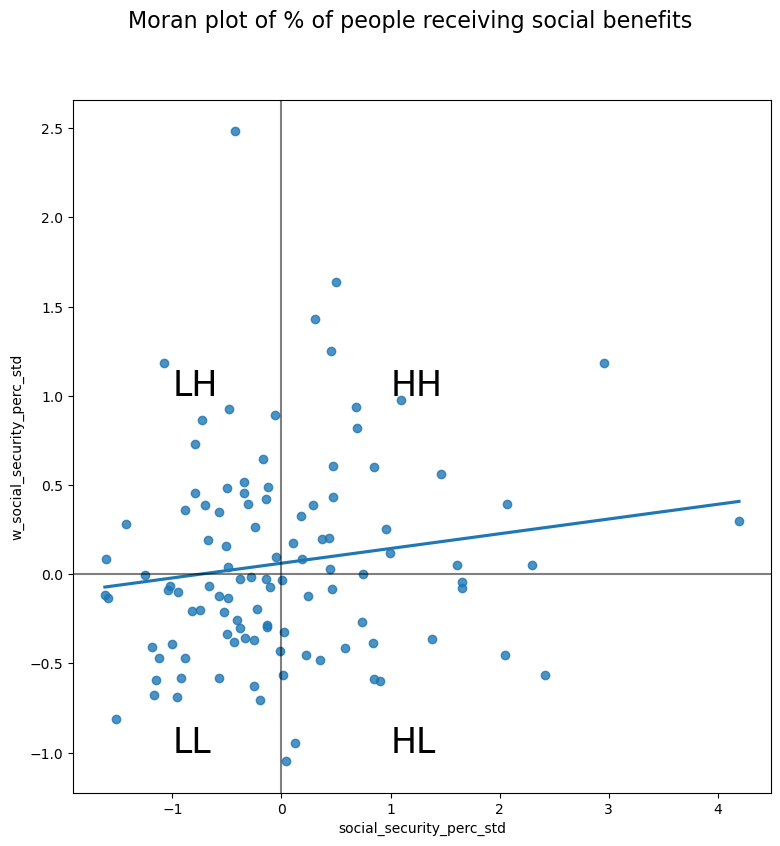

In [40]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='social_security_perc_std', y='w_social_security_perc_std', data=geo_pop_df, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1, 1, "HH", fontsize=25)
plt.text(1, -1, "HL", fontsize=25)
plt.text(-1, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
# title 
f.suptitle('Moran plot of % of people receiving social benefits', size=16)
# Display
plt.show()

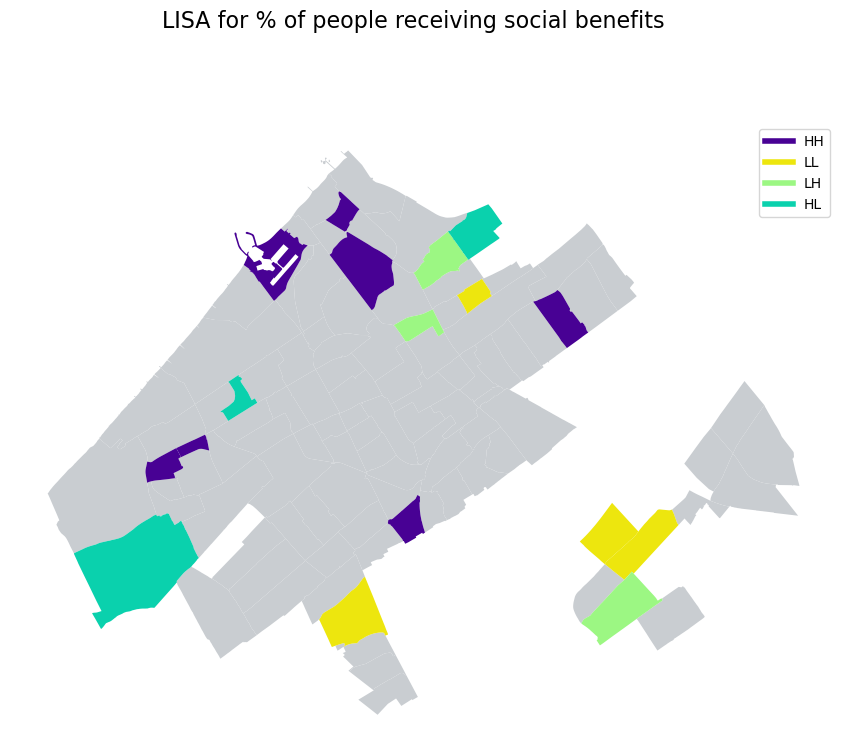

In [41]:
lisa = esda.Moran_Local(geo_pop_df['social_security_perc'], w)
# Break observations into significant or not
geo_pop_df['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
geo_pop_df['quadrant'] = lisa.q

# plot LISA
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
plt.tight_layout()
# Plot insignificant clusters
ns = geo_pop_df.loc[geo_pop_df['significant']==False, 'geometry']
ns.plot(ax=ax, color='#c9cdd1')
# Plot HH clusters (dark purple)
hh = geo_pop_df.loc[(geo_pop_df['quadrant']==1) & (geo_pop_df['significant']==True), 'geometry']
hh.plot(ax=ax, color='#480194')
# Plot LL clusters (yellow)
ll = geo_pop_df.loc[(geo_pop_df['quadrant']==3) & (geo_pop_df['significant']==True), 'geometry']
ll.plot(ax=ax, color='#ede60e')
# Plot LH clusters (green)
lh = geo_pop_df.loc[(geo_pop_df['quadrant']==2) & (geo_pop_df['significant']==True), 'geometry']
lh.plot(ax=ax, color='#9cf783')
# Plot HL clusters (turquoise)
hl = geo_pop_df.loc[(geo_pop_df['quadrant']==4) & (geo_pop_df['significant']==True), 'geometry']
hl.plot(ax=ax, color='#0ad1ad')
# Style and draw
f.suptitle('LISA for % of people receiving social benefits', size=16)
# legend
custom_lines = [Line2D([0], [0], color='#480194', lw=4),
                Line2D([0], [0], color='#ede60e', lw=4),
                Line2D([0], [0], color='#9cf783', lw=4),
               Line2D([0], [0], color='#0ad1ad', lw=4)]
ax.legend(custom_lines, ['HH', 'LL', 'LH', 'HL'])
ax.set_axis_off()
plt.show()

### 4. Regression model

In [44]:
# standardize data
# define standard scaler
scaler = StandardScaler()
# transform data
geo_pop[['low_income_perc', 'dist_gp', 'singlep_hh_perc', 'social_security_perc']] = scaler.fit_transform(geo_pop[['low_income_perc', 'dist_gp', 'singlep_hh_perc', 'social_security_perc']])
geo_pop.head()

count        gm_naam   recs    gwb_code  low_income_perc  \
neighb_cbs                                                                      
Archipelbuurt         1570  's-Gravenhage  Buurt  BU05180546        -0.675664   
Arendsdorp             400  's-Gravenhage  Buurt  BU05180478        -0.810513   
Belgisch Park         2272  's-Gravenhage  Buurt  BU05180271        -0.593014   
Bezuidenhout-Midden   1100  's-Gravenhage  Buurt  BU05182665        -0.840963   
Bezuidenhout-Oost     1071  's-Gravenhage  Buurt  BU05182666        -0.784413   

                      dist_gp  singlep_hh_perc  social_security_perc  \
neighb_cbs                                                             
Archipelbuurt       -0.900952         0.615671             -0.142954   
Arendsdorp          -0.066883        -0.168119              0.021554   
Belgisch Park        0.396489         0.266796             -0.167532   
Bezuidenhout-Midden -0.066883         0.458653             -0.961894   
Bezuidenhout-Oost   -0.622929         0.430183             -0.749659   

                      population  norm_count  
neighb_cbs                                    
Archipelbuurt        6061.666667  259.004674  
Arendsdorp           1328.333333  301.129235  
Belgisch Park        8198.333333  277.129498  
Bezuidenhout-Midden  4278.333333  257.109466  
Bezuidenhout-Oost    9028.333333  118.626546

In [45]:
# creating training and test data from our dataframe 
train_data, test_data = train_test_split(geo_pop, test_size=.2, random_state=42)

# Predictor and response array from training set 
X_train = train_data[['low_income_perc', 'dist_gp', 'singlep_hh_perc', 'social_security_perc']]
y_train = train_data['norm_count']

# Predictor and response array from test set 
X_test = test_data[['low_income_perc', 'dist_gp', 'singlep_hh_perc', 'social_security_perc']]
y_test = test_data['norm_count']

In [46]:
x = sm.add_constant(X_train) # adding a constant
 
model = sm.OLS(y_train, x).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             norm_count   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     11.28
Date:                Wed, 09 Nov 2022   Prob (F-statistic):           2.72e-07
Time:                        18:50:18   Log-Likelihood:                -547.78
No. Observations:                  84   AIC:                             1106.
Df Residuals:                      79   BIC:                             1118.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  279.2736 

In [47]:
lr_model = LinearRegression().fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.09680937349160934

### 4.1. Regression model excluding low income and GP distance

In [48]:
X_train_sub = X_train[['singlep_hh_perc', 'social_security_perc']]
X_test_sub = X_test[['singlep_hh_perc', 'social_security_perc']]

In [49]:
x_sub = sm.add_constant(X_train_sub) # adding a constant
 
model_sub = sm.OLS(y_train, x_sub).fit()
print_model = model_sub.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             norm_count   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     19.55
Date:                Wed, 09 Nov 2022   Prob (F-statistic):           1.18e-07
Time:                        18:50:18   Log-Likelihood:                -550.22
No. Observations:                  84   AIC:                             1106.
Df Residuals:                      81   BIC:                             1114.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  279.3194 

In [50]:
lr_model = LinearRegression().fit(X_train_sub, y_train)
lr_model.score(X_test_sub, y_test)

0.1471310087793325